<a href="https://colab.research.google.com/github/aortiz97-stack/JSC_Hack_2024/blob/main/debris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Project Imports

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

###Data Cleaning

In [20]:
df = pd.read_csv('satcat.csv')
df = df[df["OPS_STATUS_CODE"] != "D"]
df = df[df["ORBIT_CENTER"]=="EA"]
df = df.drop(["OBJECT_NAME", "OBJECT_ID", "NORAD_CAT_ID", "OPS_STATUS_CODE", "OWNER", "LAUNCH_DATE", "LAUNCH_SITE", "DECAY_DATE", "RCS", "DATA_STATUS_CODE", "ORBIT_CENTER", "ORBIT_TYPE", "OBJECT_TYPE"], axis=1)
df = df.dropna()
df

,PERIOD,INCLINATION,APOGEE,PERIGEE
4,132.62,34.25,3824.0,649.0
10,121.12,32.87,2910.0,552.0
11,125.50,32.91,3298.0,553.0
15,137.21,34.26,4217.0,651.0
19,124.12,33.34,3221.0,508.0
...,...,...,...,...
61821,95.09,98.00,635.0,411.0
61823,89.87,41.47,335.0,201.0
61824,91.25,41.33,475.0,196.0
61825,91.78,41.64,526.0,197.0


###Data Scaling & Outlier Removal
* Using z score to remove outliers
* Scaling:
  * Our dataset uses 4 variables to define a debris's "orbit":
    * Period is in minutes
    * Inclination is in angles (0 to 180)
    * Apogee & Perigee are in kilometers in the hundreds to thousands

In [21]:
z_scores = np.abs(zscore(df))
threshold=2
df_no_outliers = df[(z_scores < threshold).all(axis=1)]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_no_outliers)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

###KMeans Clustering
* KMeans combines all of the debris orbits into groups that are alike.
* The cluster centers give us the average debris orbit for each group.
* Using cluster centers for all of the groups, we can design an orbit for a debris removal machine to take
* The debris removal machine ideally removes all debris in each cluster
* More accurate clustering leads to more accurate orbit paths and more accurate debris removal
* We experimented with different sizes and were able to get the best evaluation scores with 7 clusters at the time we ran our code

In [22]:
random = 5
num_clusters = 7
initial_centroids = scaled_df.sample(n=num_clusters, random_state=random).values  # Example using random selection
kmeans = KMeans(n_clusters=num_clusters, init=initial_centroids, n_init=1, random_state=random)
kmeans.fit(scaled_df)

y = kmeans.labels_

print("Orbit approximation values for each cluster:")
dfa = pd.DataFrame(kmeans.cluster_centers_, columns=df.columns)
dfa

Orbit approximation values for each cluster:


,PERIOD,INCLINATION,APOGEE,PERIGEE
0,3.701758,-1.831244,4.085362,1.074957
1,4.210069,-0.553429,2.384793,7.813090
2,-0.281833,1.060204,-0.290933,-0.180076
3,-0.095601,-0.220067,-0.030079,-0.129489
4,-0.045692,1.088715,-0.056931,0.287205
5,-0.245082,0.487289,-0.259923,-0.077713
6,-0.284707,-1.112384,-0.281606,-0.244407


###Principle Component Analysis
Reducing from 4 variables to 2 variables to visualize our clusters on a 2D scatterplot

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


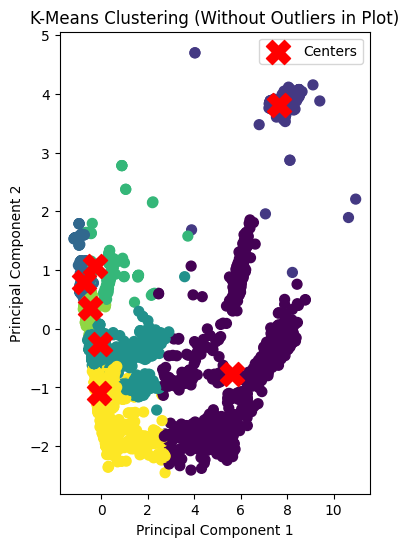

In [23]:
pca = PCA(n_components=2, random_state=random, svd_solver='full')
df_encoded_2d = pca.fit_transform(scaled_df)

plt.figure(figsize=(4, 6))
plt.scatter(df_encoded_2d[:, 0], df_encoded_2d[:, 1], c=kmeans.labels_, cmap='viridis', s=50)

cluster_centers_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(cluster_centers_2d[:, 0], cluster_centers_2d[:, 1], s=300, c='red', marker='X', label='Centers')

plt.title('K-Means Clustering (Without Outliers in Plot)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

###Evaluating our results
* The explained variance ratio tells us how much of the dataset can be explained by the two variables on the chart. We can add the two numbers to see much of dataset is visualized on the chart.

* The Silhouette Score tells us how well the clustering was. A higher value means a better clustering.

In [24]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
scaled_df

silhouette = silhouette_score(df_encoded_2d, kmeans.labels_)
print(f"Silhouette Score: {silhouette}")


Explained variance ratio: [0.66370613 0.22202981]
Silhouette Score: 0.585787954701718


###Draft Code

In [ ]:
""" Draft Code
# Create and fit the KMeans model
kmeans = KMeans(n_clusters=15, random_state=42)  # Adjust n_clusters as needed
kmeans.fit(df_encoded)

# Add the cluster labels to the DataFrame
df_encoded['Cluster'] = kmeans.labels_

# Print the cluster centers
print("Cluster centers:\n", kmeans.cluster_centers_)


pca = PCA(n_components=2)
df_encoded_2d = pca.fit_transform(df_encoded)

# Define a range for the plot (e.g., -10 to 10 for both axes)
x_range = (0, 2000)
y_range = (-5000, 5000)

# Create a mask for points within the range
mask = (df_encoded_2d[:, 0] >= x_range[0]) & (df_encoded_2d[:, 0] <= x_range[1]) & \
       (df_encoded_2d[:, 1] >= y_range[0]) & (df_encoded_2d[:, 1] <= y_range[1])

# Plot the filtered points
plt.figure(figsize=(7, 6))
plt.scatter(df_encoded_2d[mask, 0], df_encoded_2d[mask, 1], c=kmeans.labels_[mask], cmap='viridis', s=50)

# Plot cluster centers within range
cluster_centers_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(cluster_centers_2d[:, 0], cluster_centers_2d[:, 1], s=300, c='red', marker='X', label='Centers')

# Set the axis limits
plt.xlim(x_range)  # Set x-axis range
plt.ylim(y_range)  # Set y-axis range

plt.title('K-Means Clustering (Without Outliers in Plot)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)




# Reduce dimensionality to 2D for visualization (using PCA)
# pca = PCA(n_components=2)
# df_encoded_2d = pca.fit_transform(df_encoded)

# # Visualize the clusters
# plt.figure(figsize=(8, 6))
# plt.scatter(df_encoded_2d[:, 0], df_encoded_2d[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centers')

# plt.title('K-Means Clustering')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend()
# plt.show()
"""

""""scaled_df
scaled_df.plot(kind='scatter', x='Cluster', y="PERIOD")
plt.title("Debris Altitude vs Cluster")"""

'"scaled_df\nscaled_df.plot(kind=\'scatter\', x=\'Cluster\', y="PERIOD")\nplt.title("Debris Altitude vs Cluster")'